In [1]:
%matplotlib inline


Training a classifier
=====================

We will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

Training set consists of 50000 images from the above categories 

Testing set consists of 10000 images



Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data



1.Loading and normalizing CIFAR10
----------





In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images.



        ship        truck         frog        plane


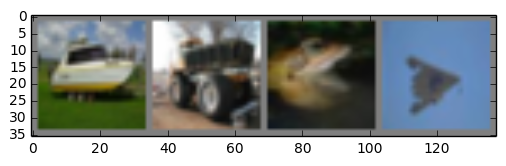

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()#next batch of 4 is given

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%12s' % classes[labels[j]] for j in range(4)))

In [5]:
dataiter = iter(trainloader)
dataiter
images, labels = dataiter.next()
images.size()
images[0]
labels.numpy()

array([9, 4, 3, 0])

2. Define a Convolution Neural Network
-------------------------------------
1. conv -> relu -> pool -> conv -> relu -> pool -> fullC -> relu -> fullC -> relu -> fullC


--(32x32x3)--

conv1 = receptive field -> (5x5x3), number of filters -> 6

--(28x28x6)--

pool1 = spatial extent ->(2x2)

--(14x14x6)--

conv2 = receptive field -> (5x5x6), number of filters -> 16

--(10x10x16)--

pool2 = spatial extent ->(2x2)

--(5x5x16)--

fullC = 120

--(120)--

fullC = 84

--(84)--

fullC = 10

--(10)--


In [117]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [34]:
#note, we have 10 sets of parameters because we have sets of bias parameters as well
#these correspond to convs and fully connected layers (and their biases) only
print(len(list(net.parameters())))
print(list(net.parameters())[0].size())
list(net.parameters())[9].size()

10
torch.Size([6, 3, 5, 5])


torch.Size([10])

In [42]:
print(net.conv1.weight.size())
print(net.conv1.bias.size())

torch.Size([6, 3, 5, 5])
torch.Size([6])


3. Define a Loss function and optimizer
------------------------------------------
Let's use a MSE loss with SGD as the optimization algorithm


In [118]:
import torch.optim as optim
#here we use MSE loss
criterion = nn.MSELoss(size_average=False) #returns us the sum over a mini-batch as opposed to the average
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train and test the network
----------------------


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize



In [110]:
#create an array to hold the MSE loss for each iteration
MSE_losses = []
MSE_acc = []

In [111]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #done in batches
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize/update weights
        outputs = net(inputs)
        
        x = labels.data.numpy()
        
        labelsVec = torch.zeros(4,10)
        labelsVec[0, x[0]] = 1
        labelsVec[1, x[1]] = 1
        labelsVec[2, x[2]] = 1
        labelsVec[3, x[3]] = 1
        
        newLabels = Variable(labelsVec, requires_grad=False)
        
        loss = criterion(outputs, newLabels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0] #loss is a variable tensor of size 1, we index to get the value out
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #   print('[%d, %5d]' % (epoch + 1, i + 1))
    MSE_loss = running_loss / 50000.0
    MSE_losses.append(MSE_loss)
    print('MSE Loss iteration %d = %.5f' % (epoch+1, MSE_loss ))
    
    correct = 0
    total = 0
    for data in testloader: #batch processing
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    acc = 100 * correct / total
    print('Accuracy of the network on the 10000 test images: %d %%' % (acc))
    MSE_acc.append(acc)

print('Finished Training')

MSE Loss iteration 1 = 0.72440
Accuracy of the network on the 10000 test images: 47 %
MSE Loss iteration 2 = 0.63442
Accuracy of the network on the 10000 test images: 53 %
MSE Loss iteration 3 = 0.59965
Accuracy of the network on the 10000 test images: 57 %
MSE Loss iteration 4 = 0.57199
Accuracy of the network on the 10000 test images: 55 %
MSE Loss iteration 5 = 0.55711
Accuracy of the network on the 10000 test images: 58 %
MSE Loss iteration 6 = 0.54421
Accuracy of the network on the 10000 test images: 56 %
MSE Loss iteration 7 = 0.53271
Accuracy of the network on the 10000 test images: 57 %
MSE Loss iteration 8 = 0.52362
Accuracy of the network on the 10000 test images: 57 %
MSE Loss iteration 9 = 0.51502
Accuracy of the network on the 10000 test images: 57 %
MSE Loss iteration 10 = 0.50571
Accuracy of the network on the 10000 test images: 57 %
MSE Loss iteration 11 = 0.50088
Accuracy of the network on the 10000 test images: 60 %
MSE Loss iteration 12 = 0.49450
Accuracy of the netw

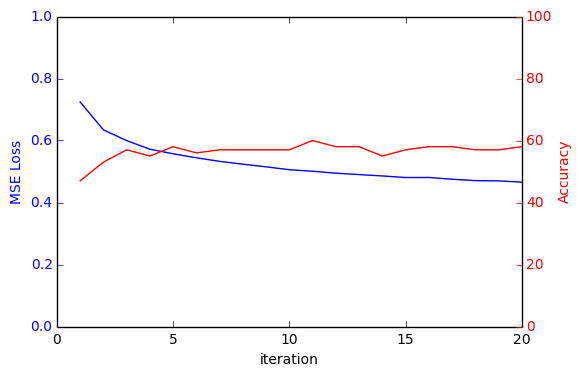

In [137]:
fig, ax1 = plt.subplots()
ax1.plot(range(1,21), MSE_losses, 'b-')
ax1.set_xlabel('iteration')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('MSE Loss', color='b')
ax1.set_ylim([0,1])
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(range(1,21), MSE_acc, 'r-')
ax2.set_ylabel('Accuracy', color='r')
ax2.set_ylim([0,100])
ax2.tick_params('y', colors='r')


plt.show()

In [72]:
for i, data in enumerate(trainloader, 0): #done in batches
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize/update weights
        outputs = net(inputs)
        _,pred = torch.max(outputs.data,1)
        #print pred
        
        #print labels.data.numpy()
        x = labels.data.numpy()
        
        labelsVec = torch.zeros(4,10)
        labelsVec[0, x[0]] = 1
        labelsVec[1, x[1]] = 1
        labelsVec[2, x[2]] = 1
        labelsVec[3, x[3]] = 1
        
        newLabels = Variable(labelsVec, requires_grad=False)
        
        loss = criterion(outputs, newLabels)
        loss.backward()
        optimizer.step()
        
        print loss.data[0]
        
        if i == 1:
            break
        

0.0752328187227
0.0807021260262


5. Test the network on the test data
----

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Let us first display an image from the test set to get familiar.



('GroundTruth: ', '   cat   ship   ship  plane')


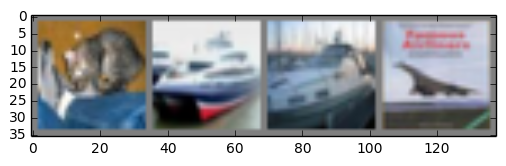

In [139]:
dataiter = iter(testloader)
#use next to iter through the testing images
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%6s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [149]:
outputs = net(Variable(images))
outputs[0,:]
torch.max(outputs.data, 1)

(
   6.3835
  13.0606
   3.0777
   8.2229
 [torch.FloatTensor of size 4], 
  9
  8
  9
  0
 [torch.LongTensor of size 4])

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [150]:
_, predicted = torch.max(outputs.data, 1) #gives a tuple object with 2 tensors, first contains max score, other indexes of class

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

('Predicted: ', 'truck  ship truck plane')


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [17]:
correct = 0
total = 0
for data in testloader: #batch processing
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

What are the classes that performed well, and the classes that did
not perform well:



In [116]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 48 %
Accuracy of  bird :  9 %
Accuracy of   cat : 16 %
Accuracy of  deer : 15 %
Accuracy of   dog : 41 %
Accuracy of  frog : 57 %
Accuracy of horse : 68 %
Accuracy of  ship : 48 %
Accuracy of truck : 53 %


Use cross entropy loss instead
---

-(sum( actual*log(predicted) ))

In [119]:
#Here we use Cross entropy loss
criterionCEL = nn.CrossEntropyLoss(size_average=False)

CE_losses = []
CE_acc = []

In [120]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterionCL(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #    print('[%d, %5d]' %(epoch + 1, i + 1))
            
    CE_loss = running_loss / 50000.0
    CE_losses.append(CE_loss)
    print('CE Loss iteration %d = %.5f' % (epoch+1, CE_loss ))
    
    correct = 0
    total = 0
    for data in testloader: #batch processing
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    
    acc = 100 * correct / total
    print('Accuracy of the network on the 10000 test images: %d %%' % (acc))
    CE_acc.append(acc)
    
print('Finished Training')

CE Loss iteration 1 = 0.42438
Accuracy of the network on the 10000 test images: 50 %
CE Loss iteration 2 = 0.32600
Accuracy of the network on the 10000 test images: 55 %
CE Loss iteration 3 = 0.28984
Accuracy of the network on the 10000 test images: 59 %
CE Loss iteration 4 = 0.26641
Accuracy of the network on the 10000 test images: 61 %
CE Loss iteration 5 = 0.24652
Accuracy of the network on the 10000 test images: 62 %
CE Loss iteration 6 = 0.23248
Accuracy of the network on the 10000 test images: 61 %
CE Loss iteration 7 = 0.22169
Accuracy of the network on the 10000 test images: 64 %
CE Loss iteration 8 = 0.21211
Accuracy of the network on the 10000 test images: 63 %
CE Loss iteration 9 = 0.20337
Accuracy of the network on the 10000 test images: 64 %
CE Loss iteration 10 = 0.19646
Accuracy of the network on the 10000 test images: 63 %
CE Loss iteration 11 = 0.18963
Accuracy of the network on the 10000 test images: 63 %
CE Loss iteration 12 = 0.18354
Accuracy of the network on the 1

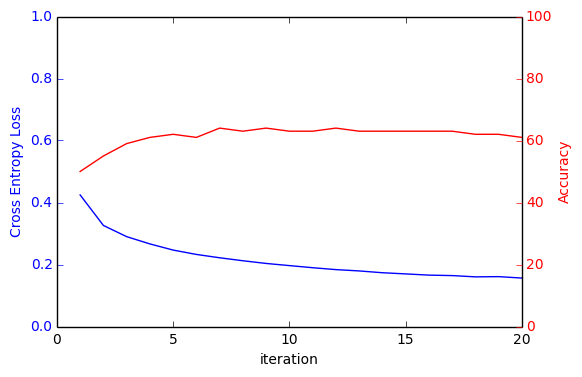

In [136]:
fig, ax1 = plt.subplots()
ax1.plot(range(1,21), CE_losses, 'b-')
ax1.set_xlabel('iteration')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Cross Entropy Loss', color='b')
ax1.set_ylim([0,1])
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(range(1,21), CE_acc, 'r-')
ax2.set_ylabel('Accuracy', color='r')
ax2.set_ylim([0,100])
ax2.tick_params('y', colors='r')


plt.show()

In [126]:
range(1,20)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]